In [52]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras import optimizers
from keras import metrics
from keras import models
import tensorflow
import functools
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import common

print(tensorflow.config.list_physical_devices('GPU'))
print(tensorflow.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [2]:
train = common.load_train_dataset('dataset_mini/train.csv')

train.loc[~train["attribute_ids"].isin(["51", "13"]), "attribute_ids"] = "-1"

print('Number of train samples: ', train.shape[0])
display(train.head())

test = common.load_train_dataset('dataset_mini/test.csv')

test.loc[~test["attribute_ids"].isin(["51", "13"]), "attribute_ids"] = "-1"

print('Number of test samples: ', test.shape[0])
display(test.head())

Number of train samples:  19999


,id,attribute_ids
12080,93d597792098c969.png,13
19002,df6290c9a49f9f34.png,51
16178,bfd56556fb197c03.png,13
5661,4db51950bbc89dd5.png,51
3778,38f9ba35cfc472cf.png,51


Number of test samples:  2097


,id,attribute_ids
865,f31b10faf3a1bd28.png,13
1030,f4f5a462fff5ad12.png,13
206,ec7bd0302e998677.png,13
210,ec8d0ad3c6acbcfc.png,13
1413,f8ef6a39aeddae.png,13


In [3]:
# Model parameters
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 3

In [4]:
train_generator, valid_generator, test_generator = common.create_image_generators("dataset_mini/data", "dataset_mini/data", train, test, BATCH_SIZE, (HEIGHT, WIDTH), data_augmentation=True)

class_weights = class_weight.compute_class_weight("balanced",
                                                 y=np.unique(train_generator.classes),
                                                 classes=np.array(train_generator.classes))
class_weights = dict(enumerate(class_weights))

C:\Users\henri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 20 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
Found 15984 validated image filenames belonging to 3 classes.
Found 3995 validated image filenames belonging to 3 classes.
Found 2097 validated image filenames belonging to 3 classes.
C:\Users\henri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 20 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [5]:
model = models.Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation="softmax"))
model.summary()

optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 32)        11648     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0

In [6]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    verbose=1)

model.save('task1_cnn_3')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
499/499 [==============================] - 235s 443ms/step - loss: 1.4248 - accuracy: 0.4695 - val_loss: 1.1305 - val_accuracy: 0.4647
Epoch 2/20
499/499 [==============================] - 220s 441ms/step - loss: 1.1303 - accuracy: 0.5188 - val_loss: 1.0572 - val_accuracy: 0.5428
Epoch 3/20
499/499 [==============================] - 224s 449ms/step - loss: 1.0502 - accuracy: 0.5458 - val_loss: 1.1629 - val_accuracy: 0.4960
Epoch 4/20
499/499 [==============================] - 222s 445ms/step - loss: 1.0236 - accuracy: 0.5471 - val_loss: 0.9401 - val_accuracy: 0.5653
Epoch 5/20
499/499 [==============================] - 221s 444ms/step - loss: 0.9754 - accuracy: 0.5705 - val_loss: 1.2182 - val_accuracy: 0.4587
Epoch 6/20
499/499 [==============================] - 221s 444ms/step - loss: 0.9635 - accuracy: 0.5734 - val_loss: 1.0408 - val_acc

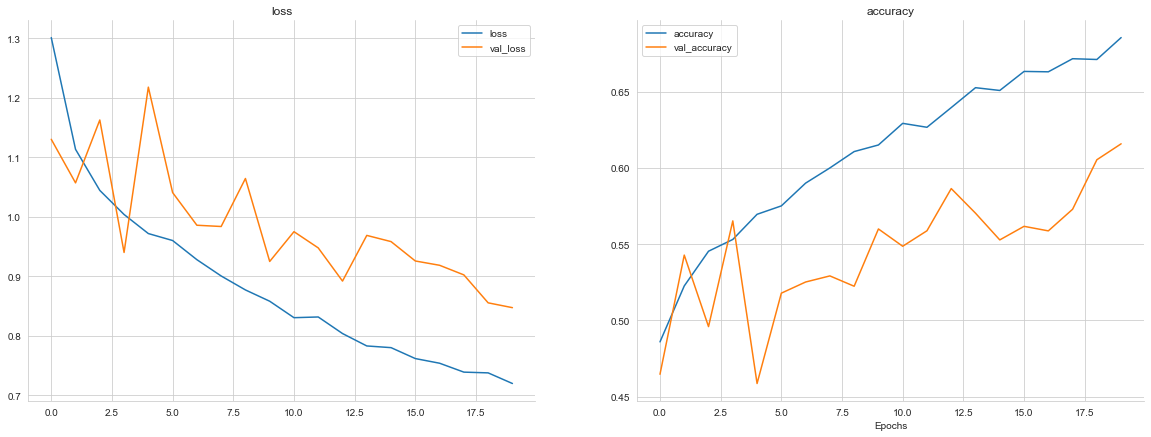

In [49]:
common.plot_history(history, ["loss", "accuracy"])

In [8]:
model = models.load_model('task1_cnn_3')
model.evaluate(test_generator, verbose=1)

2097/2097 [==============================] - 10s 4ms/step - loss: 1.6921 - accuracy: 0.3977


[1.6921055316925049, 0.39771100878715515]

In [66]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)

matrix = confusion_matrix(test_generator.classes, preds)
print(matrix)
class_labels = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, preds, target_names=class_labels))

[[ 89  39 363]
 [ 78 110 700]
 [ 61  22 635]]
              precision    recall  f1-score   support

          -1       0.39      0.18      0.25       491
          13       0.64      0.12      0.21       888
          51       0.37      0.88      0.53       718

    accuracy                           0.40      2097
   macro avg       0.47      0.40      0.33      2097
weighted avg       0.49      0.40      0.33      2097

